In [1]:
import requests
import os

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/nasdaq.csv'

import pandas as pd

df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


In [2]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [3]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6169
삭제 후 데이터 길이(일자수): 5097


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

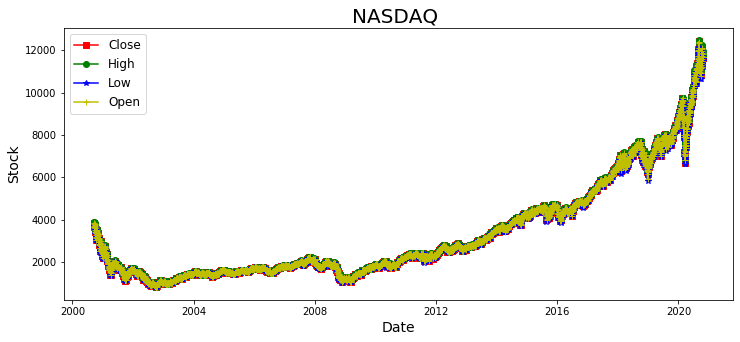

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [5]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


# 2 기본 통계분석으로 이상치 찾기

0.0


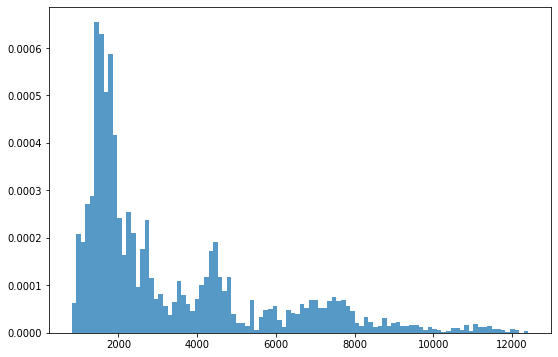

In [6]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest

fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

_, p = ztest(df.Close)
print(p)

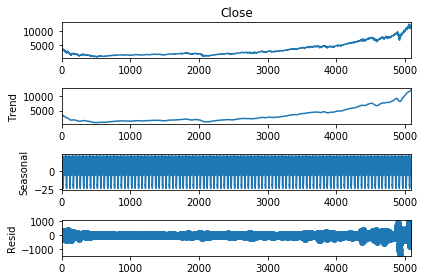

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

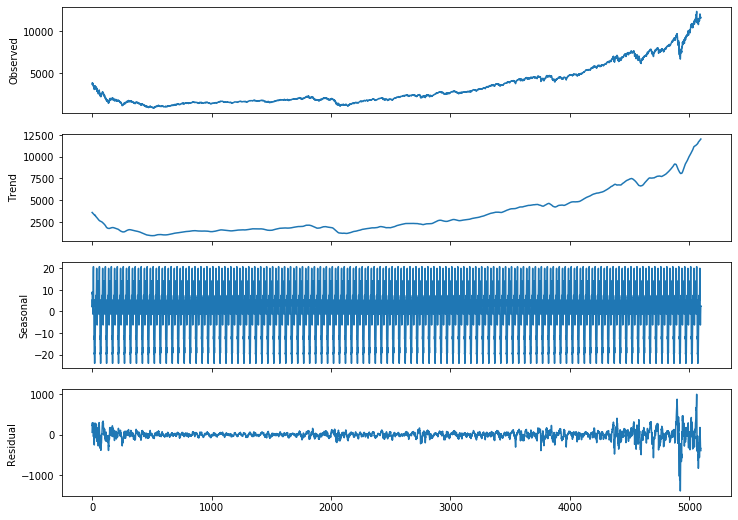

In [8]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

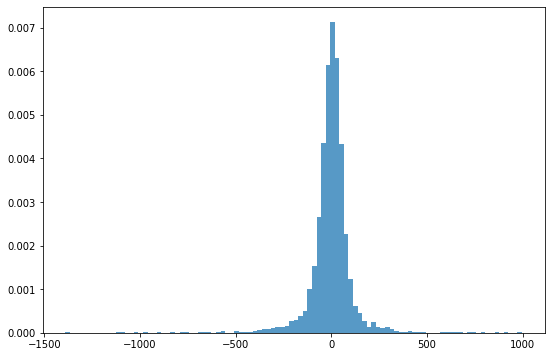

In [9]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [10]:
r = result.resid.values
st, p = ztest(r)
print("st value is : {0} p value is : {1}".format(st,p))

st value is : -0.8522496995036497 p value is : 0.39407551750052994


In [11]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.313906361677976 표준편차: 110.0664287457301
이상치 갯수: 95


In [12]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5086   2020-10-08
5093   2020-10-19
5094   2020-10-20
5095   2020-10-21
5096   2020-10-22
Name: Date, Length: 95, dtype: datetime64[ns]

# 3. Unsupervised Clustering 으로 이상치 찾기

In [13]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5097.000000,5097.000000,5097.000000,5097.000000,5097.000000
mean,3329.118618,3360.581337,3296.950210,3330.997045,287988.011319
std,2398.388176,2420.273190,2377.217548,2402.305499,109739.725261
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.340000,1597.610000,1571.100000,1584.276001,220570.770000
50%,2264.705000,2291.690000,2232.192500,2264.982500,268897.250000
75%,4433.907500,4465.685000,4400.967500,4435.272500,319670.180000
max,12046.249464,12205.163635,11877.272025,12052.571806,776809.340000


In [14]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5097.000000,5097.000000,5097.000000,5097.000000,5097.000000
mean,-1.389481,-1.415631,-1.275371,-1.334106,162.468983
std,112.458034,102.142678,116.646385,110.222420,110730.691639
min,-1280.483047,-1494.583444,-1226.888145,-1390.096658,-602954.910733
25%,-38.123741,-35.277082,-38.410498,-37.721638,-53334.836389
50%,3.432113,3.376359,4.072309,2.958272,-492.600487
75%,40.282673,37.530846,41.728350,40.844126,51622.953177
max,996.926304,933.615919,941.529412,996.300897,810720.467889


In [15]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.38948086  -1.41563149  -1.27537141  -1.33410601 162.46898264]


array([[ 0.94716208,  0.84570641,  0.8160061 ,  0.6009286 ,  0.08320764],
       [ 0.48936005,  1.283057  ,  1.3862533 ,  2.09233495,  0.10452471],
       [ 1.90396838,  2.01658117,  2.04492858,  2.73371252, -0.08886621],
       ...,
       [-2.74272049, -3.62515399, -2.08239522, -3.19840343,  0.6827219 ],
       [-3.13456834, -3.96398901, -2.38015451, -3.13021572,  0.47180826],
       [-3.23218209, -4.66061227, -3.20590445, -3.66350521,  0.56377243]])

In [16]:
# k-means 로 이상치 탐색하기

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[0 0 0 ... 1 1 1]


In [17]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[4129  968]


In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:729',
 'group:1-count:1037',
 'group:2-count:261',
 'group:3-count:32',
 'group:4-count:98',
 'group:5-count:20',
 'group:6-count:286',
 'group:7-count:153',
 'group:8-count:11',
 'group:9-count:789',
 'group:10-count:104',
 'group:11-count:62',
 'group:12-count:849',
 'group:13-count:404',
 'group:14-count:262']

In [19]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==3)|(kmeans.labels_==9)|(kmeans.labels_==10)]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.000000,3785.5,3602.000000,3653.500000,3653.500000,72994.0
2,2000-09-20,3801.500000,3874.0,3715.500000,3853.000000,3853.000000,78832.0
3,2000-09-21,3852.000000,3874.0,3744.000000,3765.000000,3765.000000,70719.0
5,2000-09-25,3776.500000,3830.0,3660.000000,3675.000000,3675.000000,51490.0
8,2000-09-28,3640.500000,3780.0,3607.000000,3758.000000,3758.000000,61459.0
...,...,...,...,...,...,...,...
5083,2020-10-05,11308.500000,11497.5,11267.500000,11469.200195,11469.200195,398444.0
5084,2020-10-06,11473.000000,11524.5,11197.500000,11273.799805,11273.799805,612278.0
5085,2020-10-07,11220.500000,11506.5,11208.000000,11470.000000,11470.000000,443046.0
5090,2020-10-14,12079.799805,12178.0,11901.799805,11974.200195,11974.200195,597198.0


In [20]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5097.000000,5097.000000,5097.000000,5097.000000,5097.000000,5.097000e+03
mean,3327.722521,3359.159792,3295.667440,3329.656394,3329.656394,2.881619e+05
std,2398.369859,2419.552584,2377.879993,2402.170957,2402.170957,1.595578e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1593.000000,1608.500000,1576.500000,1593.000000,1593.000000,1.907490e+05
50%,2231.000000,2259.750000,2211.500000,2232.250000,2232.250000,2.657150e+05
75%,4447.000000,4467.250000,4419.250000,4450.250000,4450.250000,3.561590e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [21]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.412423,-0.426083,-0.358067,-0.366782,-0.065853
1,0.101570,0.095408,0.147072,0.129574,-0.329592
2,1.069637,1.108876,1.157531,1.137764,-0.411966
3,-4.297818,-4.626367,-4.284899,-4.263661,0.710669
4,-2.198994,-2.249134,-2.115708,-2.116222,-0.175964
5,6.067089,6.117151,6.116227,6.036096,-0.222445
6,0.422347,0.423038,0.507370,0.495880,-1.633568
7,0.142768,0.096533,-0.357444,-0.306406,2.294580
8,-8.528182,-7.585937,-8.585452,-7.700270,-2.334964
9,0.512502,0.544999,0.512553,0.516380,0.065600


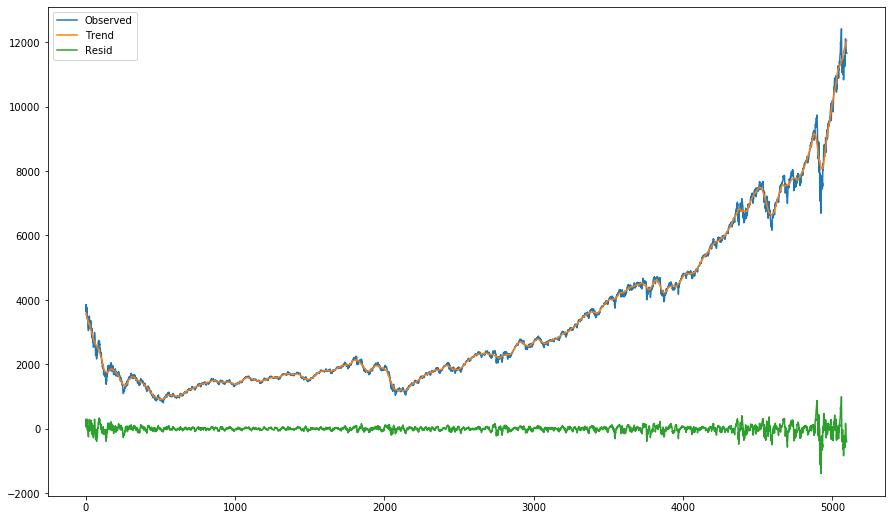

In [22]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

In [23]:
# 코로나로 인해 잔차가 깊게 파인부분이 관측됍니다. 

In [24]:
#DBSCAN 으로 이상치 찾기
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

In [25]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0 ... 22 22 -1]


In [26]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:198',
 'group:0-count:4840',
 'group:1-count:2',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:3',
 'group:21-count:2',
 'group:22-count:3',
 'group:23-count:2']

# 4. LSTM 오토인코더로 이상치 찾기

In [27]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [29]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [30]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [31]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [32]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [33]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
157/159 [============================>.] - ETA: 0s - loss: 1.1104 - mae: 1.1104
Epoch 00001: val_loss improved from inf to 1.02358, saving model to /home/aiffel/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 1s 9ms/step - loss: 1.0982 - mae: 1.0982 - val_loss: 1.0236 - val_mae: 1.0236
Epoch 2/50
153/159 [===========================>..] - ETA: 0s - loss: 0.5007 - mae: 0.5007
Epoch 00002: val_loss improved from 1.02358 to 0.54964, saving model to /home/aiffel/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 1s 7ms/step - loss: 0.4896 - mae: 0.4896 - val_loss: 0.5496 - val_mae: 0.5496
Epoch 3/50
152/159 [===========================>..] - ETA: 0s - loss: 0.4151 - mae: 0.4151
Epoch 00003: val_loss did not improve from 0.54964
159/159 [==============================] - 1s 7ms/step - loss: 0.4122 - mae: 0.4122 - val_loss: 0.5930 - val_mae: 0.5930
Epoch 4/50
153/159 [===========================>..] - ETA

In [34]:
model.load_weights(checkpoint_path)

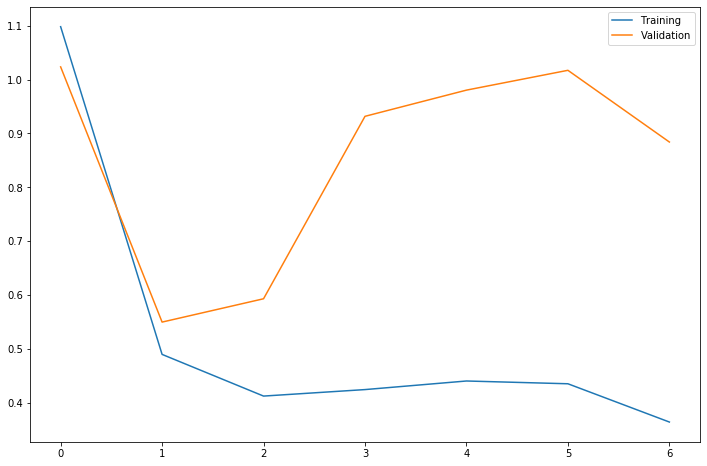

In [35]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

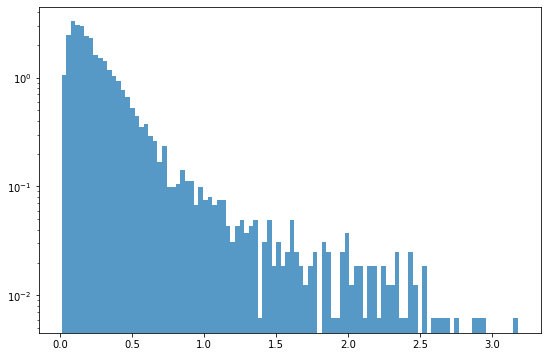

In [36]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [37]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
5048,2020-08-30,12002.75,12040.0,11998.0,12037.0,12037.0,354186.0,3.178307


In [38]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
0,2000-10-02,3621.000000,3668.000000,3492.000000,3528.500000,3528.500000,63100.0,0.532789
1,2000-10-03,3529.000000,3603.000000,3385.000000,3397.000000,3397.000000,78732.0,0.607821
2,2000-10-04,3426.500000,3477.500000,3334.000000,3477.500000,3477.500000,77551.0,0.643209
3,2000-10-05,3460.500000,3537.000000,3431.500000,3482.500000,3482.500000,69864.0,0.558815
4,2000-10-06,3490.000000,3509.500000,3305.000000,3357.500000,3357.500000,69256.0,0.588909
...,...,...,...,...,...,...,...,...
5082,2020-10-16,11891.000000,12022.000000,11792.000000,11798.000000,11798.000000,527026.0,2.696785
5083,2020-10-19,11816.799805,11950.500000,11591.200195,11650.200195,11650.200195,623203.0,2.431921
5084,2020-10-20,11697.500000,11792.000000,11598.500000,11660.799805,11660.799805,622702.0,2.314765
5085,2020-10-21,11675.200195,11779.200195,11585.000000,11691.200195,11691.200195,599851.0,2.389323


/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/lines.py:195: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


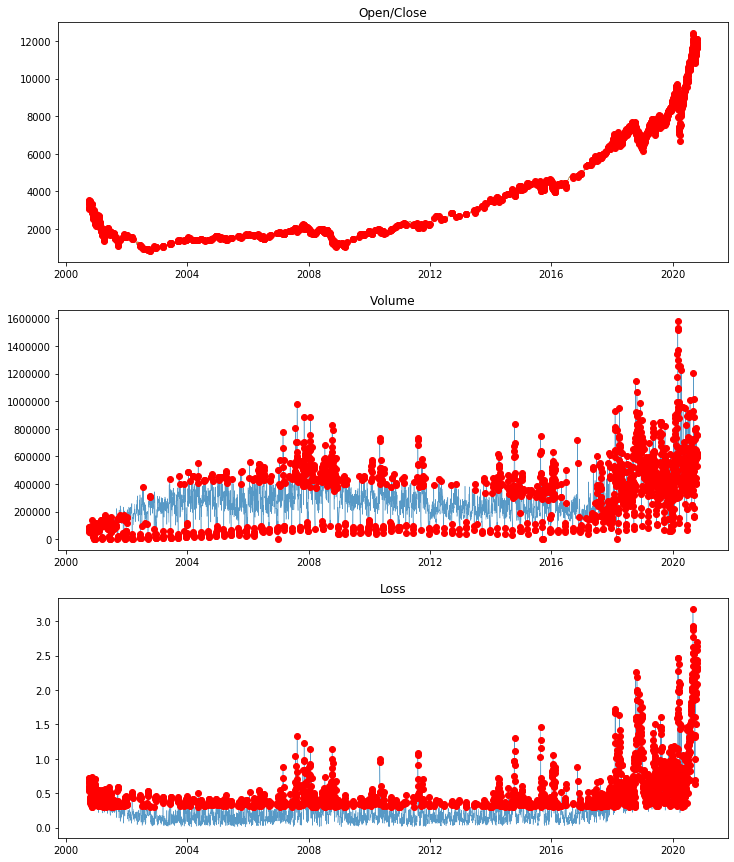

In [39]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

In [40]:
# 아무래도 Date 를 MAX 로 하여 모든 데이터를 뽑다보니, 데이터가 방대해져서 결측치들이 많이 보이는것을 관측할수가 있었습니다.